In [1]:
#Packages import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import math
import astropy.units as u

In [2]:
# Search for your target using its TIC ID 
TIC = 'TIC 86396382'

In [3]:
# Check the availability of the data for this target
available_data_all = lk.search_lightcurve(TIC, author = 'SPOC')
available_data_all

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 20,2019,SPOC,120,86396382,0.0
1,TESS Sector 43,2021,SPOC,120,86396382,0.0
2,TESS Sector 44,2021,SPOC,120,86396382,0.0
3,TESS Sector 45,2021,SPOC,120,86396382,0.0


In [4]:
available_data_all

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 20,2019,SPOC,120,86396382,0.0
1,TESS Sector 43,2021,SPOC,120,86396382,0.0
2,TESS Sector 44,2021,SPOC,120,86396382,0.0
3,TESS Sector 45,2021,SPOC,120,86396382,0.0


In [5]:
# Select multiple sectors or a single sector based on the available data above.To select multiple sectors,
# change the parenthesis from [number] to [ beginning sector : ending sector ]
select_sectors = available_data_all[0:3]

In [6]:
# Download and illustrate multiple sectors.
collect_lc = select_sectors.download_all()

In [7]:
# Stitch the different sectors together, this '.stitch()' function also normalized the data for us
collect_lc = collect_lc.stitch()

<IPython.core.display.Javascript object>


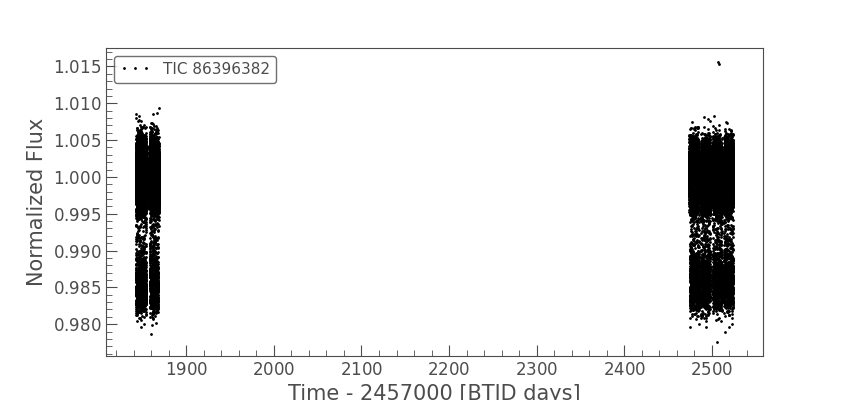

<AxesSubplot: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

In [8]:
collect_lc.plot(color = 'black', lw = 0, marker = '.')

<IPython.core.display.Javascript object>


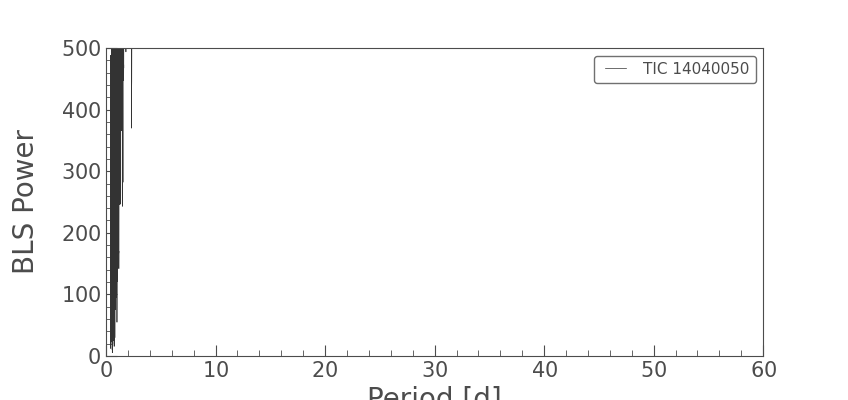

Period at max power = 20.535933593359335 d
BLS max power = 15886.12636340124


In [9]:
#Here we use the Box Least Square method with a periodogram to search for periodic signals and calculate the exoplanet's period
import numpy as np
import matplotlib.pyplot as plt
period = np.linspace(0.4,30, 10000) # (start,end,steps). You can change the start and end timeframe.
bls = collect_lc.to_periodogram(method='bls', period=period);
bls.plot();
plt.ylabel('BLS Power', fontsize=20, labelpad=15)
plt.xlabel('Period [d]', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#Limits on x and y axis are given manually. You may need to change them depedning on the timeframe given.
plt.xlim(0,60) 
plt.ylim([0,500])

print('Period at max power =',bls.period_at_max_power)
print('BLS max power =', bls.max_power)

<IPython.core.display.Javascript object>


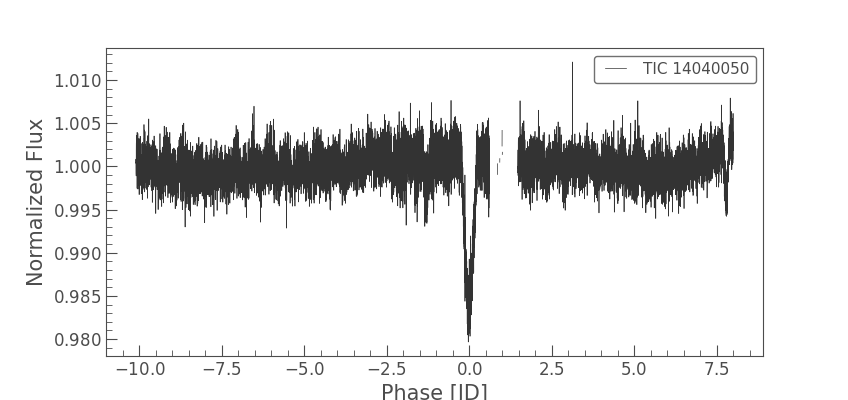

<IPython.core.display.Javascript object>


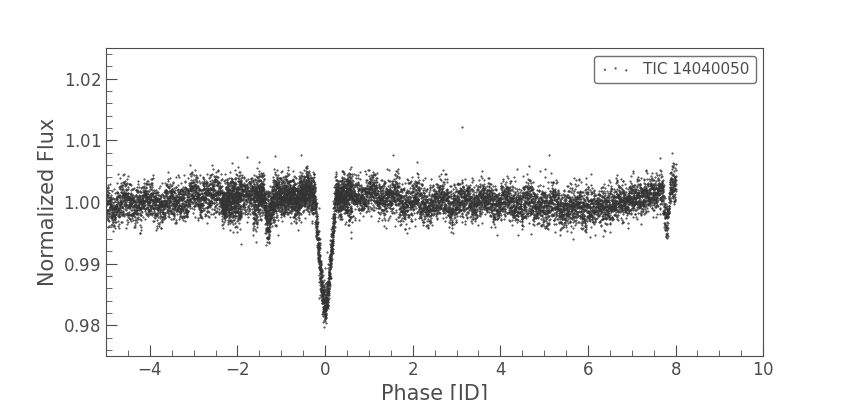

(0.975, 1.025)

In [15]:
#Here we will fold the lightcurve based on the period and the epoch time we found earlier.
#After folding your light curve you should see a signal (transit) on phase 0.
folded_lc = collect_lc.fold(bls.period_at_max_power, epoch_time=bls.transit_time_at_max_power)
folded_lc.plot();
folded_lc.scatter(s=1)
#Limits on x and y axis are given manually. You may need to change them.
plt.xlim(-5,10)
plt.ylim([0.975,1.025])

In [18]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

In [19]:
planet_b_dur
print('Transit duration in hours=', planet_b_dur*24, 'hours')

Transit duration in hours= 3.5999999999999996 d hours


In [20]:
#Transit depth from bls model
planet_b_depth = bls.depth_at_max_power
print('depth = ', planet_b_depth)
print('depth in ppm =', planet_b_depth * (10**6), 'ppm')

depth =  0.006091324410712443
depth in ppm = 6091.324410712443 ppm


In [21]:
print(bls.period_at_max_power)
print(bls.transit_time_at_max_power)
print(bls.duration_at_max_power)

1.764696469646965 d
2420.7268503705773
0.15 d


# Exoplanet properties calculations
Search the target's TIC ID at https://exofop.ipac.caltech.edu/tess/ to get the star's properties needed for the calculations below.

In [14]:
P = 8.903703703703705 * 24 * 60 * 60 #planet's period
G = 6.674* 10 ** -11 #gravitational constant
Msun = 1.98847 * 10**30 #Sun mass
M = 1.1 * Msun #Star's mass
pi = math.pi
a = ((P**2)/((4*pi**2)/(G*M)))**(1/3) #Orbital radius or semi-major axis
print('Orbital Radius')
print('a =',a , 'm')
print('a =',a/1000 , 'km')
print('a =',a/1000 * 0.000000006684587, 'AU')
print('The planetary mass was neglected')

Orbital Radius
a = 12982819697.367685 m
a = 12982819.697367685 km
a = 0.08678478777236796 AU
The planetary mass was neglected


In [15]:
Rs = 1.49834 #Star's radius
Rsun  = 696340 #Sun radius
Rearth = 6371 #Earth radius
Rpbls = (Rs * planet_b_depth ** (1/2)) * Rsun #Exoplanet's radius derived from bls model
print('Planet Radius from bls model')
print('Rp =', Rpbls, 'km')
print('Rp=',Rpbls/Rearth, 'Rearth')
aRsbls = (a/1000)/(Rs*Rsun)
print('Orbital Period and Star Radius ratio from bls model')
print('a/Rs =', aRsbls)

Planet Radius from bls model
Rp = 55398.08181987254 km
Rp= 8.69535109399977 Rearth
Orbital Period and Star Radius ratio from bls model
a/Rs = 12.443349770691867


In [16]:
P =  8.903703703703705 * 24 * 60 * 60
pi = math.pi
a =  12982819697.367685 #semi-major axis in meters
v = (2*pi*a/P)
print('Planet Velocity')
print('v =',v , 'm/s')

Planet Velocity
v = 106038.71408103987 m/s


*** Summing up all calculated properties ***

In [17]:
print('Period = ',bls.period_at_max_power)
print('Transit duration in hours planet disk fully superimposed to the stellar disk positions 2 - 3 Tf = ', bls.duration_at_max_power*24,'hours')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Transit Depth from bls model = ', planet_b_depth)
print('Transit Depth from bls model in ppm =', planet_b_depth * (10**6), 'ppm')
ratiobls = np.sqrt(planet_b_depth)
print('Rp/Rs ratio from bls model= ', ratiobls)
print('- - - - - - - - - - - - - - - - - - - - ')
print('Planet Radius from bls model')
print('Rp =', Rpbls, 'km')
print('Rp=',Rpbls/Rearth, 'Rearth')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Orbital Radius')
print('a =',a , 'm')
print('a =',a/1000 , 'km')
print('a =',a/1000 * 0.000000006684587, 'AU')
print('The planetary mass was neglected')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Orbital Period and Star Radius ratio')
print('a/Rs', aRsbls)
print('- - - - - - - - - - - - - - - - - - - - ')
print('Planet Velocity')
print('v =',v , 'm/s')
print('- - - - - - - - - - - - - - - - - - - - ')


Period =  8.903703703703705 d
Transit duration in hours planet disk fully superimposed to the stellar disk positions 2 - 3 Tf =  2.4000000000000004 d hours
- - - - - - - - - - - - - - - - - - - - 
Transit Depth from bls model =  0.0028192008719208727
Transit Depth from bls model in ppm = 2819.200871920873 ppm
Rp/Rs ratio from bls model=  0.05309614743011844
- - - - - - - - - - - - - - - - - - - - 
Planet Radius from bls model
Rp = 55398.08181987254 km
Rp= 8.69535109399977 Rearth
- - - - - - - - - - - - - - - - - - - - 
Orbital Radius
a = 12982819697.367685 m
a = 12982819.697367685 km
a = 0.08678478777236796 AU
The planetary mass was neglected
- - - - - - - - - - - - - - - - - - - - 
Orbital Period and Star Radius ratio
a/Rs 12.443349770691867
- - - - - - - - - - - - - - - - - - - - 
Planet Velocity
v = 106038.71408103987 m/s
- - - - - - - - - - - - - - - - - - - - 


In [18]:
import cmath
print('Calculations from bls model')
#FROM BLS MODEL
#Calculation of total transit duration Tt
Tt = ((((4 * 8.903703703703705**(2) * 0.0028192008719208727 ** (1/2))/(math.pi ** 2)) * (((Rs*Rsun)/(a/1000))**(2))) + (0.1 ** (2))) ** (1/2)
print('Total transit duration T14 Tt =', Tt)
print('Tt in hours =', Tt * 24, 'hours')
#Calculation of the impact parameter b for eccentricity e=0
#b = (( ((1-(Tdepth **(1/2)))**(2)-(planet_b_dur/Tt)**(2))* (1+(Tdepth **(1/2)))**(2)  ) / (1 - (planet_b_dur/Tt)**(2) ) ) ** (1/2)
b = abs(( ((1-cmath.sqrt(0.0028192008719208727))**(2)-(0.1/Tt)**(2)) * (1+cmath.sqrt(0.0028192008719208727))**(2)  ) / cmath.sqrt(1 - (0.1/Tt)**(2) ))
print('Impart parameter b =', b)
#Calculation of inclination
i = cmath.acos(b*(Rs*Rsun)/(a/1000))
print('Inclination i =', 90-i, 'deg')

Calculations from bls model
Total transit duration T14 Tt = 0.14497474614586126
Tt in hours = 3.47939390750067 hours
Impart parameter b = 0.6446102877293107
Inclination i = (88.48103046923761+0j) deg


In [19]:
import cmath
print('Calculations from bls model')
#FROM BLS MODEL
#Calculation of total transit duration Tt
Tt = ((((4 * period **(2) * planet_b_depth ** (1/2))/(math.pi ** 2)) * (((Rs*Rsun)/(a/1000))**(2))) + (planet_b_dur ** (2))) ** (1/2)
print('Total transit duration T14 Tt =', Tt)
print('Tt in hours =', Tt * 24, 'hours')
#Calculation of the impact parameter b for eccentricity e=0
#b = (( ((1-(Tdepth **(1/2)))**(2)-(planet_b_dur/Tt)**(2))* (1+(Tdepth **(1/2)))**(2)  ) / (1 - (planet_b_dur/Tt)**(2) ) ) ** (1/2)
b = abs(( ((1-cmath.sqrt(planet_b_depth))**(2)-(planet_b_dur/Tt)**(2)) * (1+cmath.sqrt(planet_b_depth))**(2)  ) / cmath.sqrt(1 - (planet_b_dur/Tt)**(2) ))
print('Impart parameter b =', b)
#Calculation of inclination
i = cmath.acos(b*(Rs*Rsun)/(a/1000))
print('Inclination i =', 90-i, 'deg')

Calculations from bls model


UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

In [ ]:
lk.show_citation_instructions()